In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

import random
import math
import networkx as nx

import boto3
from PIL import Image

import requests
import json

from tqdm import tqdm
getattr(tqdm, '_instances', {}).clear()  # ⬅ add this line

%matplotlib inline

plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)

In [170]:
import pickle # save images
import time # get time stamp of models trained

In [171]:
import matplotlib.image as mpimg # show images
from io import BytesIO # reading bytes

In [7]:
bird_orders = pd.read_csv('data/eBird-Clements-v2019-integrated-checklist-August-2019.csv', encoding = "ISO-8859-1", error_bad_lines=False)

In [8]:
bird_orders.head()

,eBird species code 2019,TAXON_ORDER,category,English name,scientific name,range,order,family,eBird species group,extinct,extinct year
0,ostric2,1.0,species,Common Ostrich,Struthio camelus,NaN,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN,NaN
1,NaN,2.0,subspecies,NaN,Struthio camelus camelus,Sahel of North Africa and the Sudan,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN,NaN
2,NaN,3.0,subspecies,NaN,Struthio camelus syriacus,Formerly Syrian and Arabian deserts. Extinct c...,Struthioniformes,Struthionidae (Ostriches),Ostriches,1.0,1966
3,NaN,4.0,subspecies,NaN,Struthio camelus massaicus,S Kenya and e Tanzania,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN,NaN
4,NaN,5.0,subspecies,NaN,Struthio camelus australis,Southern Africa,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN,NaN


In [82]:
bird_orders.columns = ['eBird_code', 'order_num', 'category', 'txt_labels',
       'sci_name', 'range', 'order', 'family', 'species_group',
       'extinct', 'extinct_year']

In [83]:
bird_orders.head(1)

,eBird_code,order_num,category,txt_labels,sci_name,range,order,family,species_group,extinct,extinct_year
0,ostric2,1.0,species,Common Ostrich,Struthio camelus,NaN,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN,NaN


In [91]:
bird_orders[bird_orders['txt_labels'] == 'Harlequin Duck']

,eBird_code,order_num,category,txt_labels,sci_name,range,order,family,species_group,extinct,extinct_year
625,harduc,626.0,species,Harlequin Duck,Histrionicus histrionicus,"breeds eastern Siberia and northern Japan, Ala...",Anseriformes,"Anatidae (Ducks, Geese, and Waterfowl)",Waterfowl,NaN,NaN


In [79]:
bird_orders['order'].unique()

array(['Struthioniformes', 'Rheiformes', 'Tinamiformes', 'Casuariiformes',
       'Apterygiformes', 'Anseriformes', 'Galliformes',
       'Phoenicopteriformes', 'Podicipediformes', 'Columbiformes',
       'Mesitornithiformes', 'Pterocliformes', 'Otidiformes',
       'Musophagiformes', 'Cuculiformes', 'Caprimulgiformes',
       'Opisthocomiformes', 'Gruiformes', 'Charadriiformes',
       'Eurypygiformes', 'Phaethontiformes', 'Gaviiformes',
       'Sphenisciformes', 'Procellariiformes', 'Ciconiiformes',
       'Suliformes', 'Pelecaniformes', 'Cathartiformes',
       'Accipitriformes', 'Strigiformes', 'Coliiformes',
       'Leptosomiformes', 'Trogoniformes', 'Bucerotiformes',
       'Coraciiformes', 'Galbuliformes', 'Piciformes', 'Cariamiformes',
       'Falconiformes', nan, 'Psittaciformes', 'Passeriformes'],
      dtype=object)

In [11]:
master_df = pd.read_csv('data/master_df.csv', index_col=0)

In [12]:
master_df.head(5)

,file_path,img_name,class_id,txt_labels
0,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0000139e-21dc-4d0c-bfe1-4cae3c85c829,817,Oak Titmouse
1,0817/01a472d8e93047a080aae4f958a2ef47.jpg,01a472d8-e930-47a0-80aa-e4f958a2ef47,817,Oak Titmouse
2,0817/036fba7c96374635853511ead2c1c728.jpg,036fba7c-9637-4635-8535-11ead2c1c728,817,Oak Titmouse
3,0817/07814887f59b44cb9b7f399999634fba.jpg,07814887-f59b-44cb-9b7f-399999634fba,817,Oak Titmouse
4,0817/0822865741de43128a6a6c8897387975.jpg,08228657-41de-4312-8a6a-6c8897387975,817,Oak Titmouse


In [108]:
import re

master_df['txt_labels'] = master_df['txt_labels'].str.replace(r'\([\s\S]*\)', '').str.strip()

In [113]:
orders = bird_orders[['order','txt_labels', 'family', 'species_group']].copy()

In [114]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34501 entries, 0 to 34500
Data columns (total 4 columns):
order            34499 non-null object
txt_labels       16513 non-null object
family           34492 non-null object
species_group    34501 non-null object
dtypes: object(4)
memory usage: 1.1+ MB


In [179]:
orders['order'].nunique()

41

In [94]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48562 entries, 0 to 48561
Data columns (total 4 columns):
file_path     48562 non-null object
img_name      48562 non-null object
class_id      48562 non-null int64
txt_labels    48562 non-null object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


In [128]:
orders_df = master_df.merge(orders, on='txt_labels')

In [172]:
orders_df['family'].nunique()

43

In [173]:
orders_df['species_group'].nunique()

38

In [148]:
# orders_df.to_csv('data/orders_df.csv')

In [176]:
orders_df.head(2)

,file_path,img_name,class_id,txt_labels,order,family,species_group
0,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0000139e-21dc-4d0c-bfe1-4cae3c85c829,817,Oak Titmouse,Piciformes,Picidae (Woodpeckers),Woodpeckers
1,0817/01a472d8e93047a080aae4f958a2ef47.jpg,01a472d8-e930-47a0-80aa-e4f958a2ef47,817,Oak Titmouse,Piciformes,Picidae (Woodpeckers),Woodpeckers


In [178]:
orders_df['order'].nunique()

18

In [175]:
len(orders_df)

48271

In [182]:
sum(orders_df['order'].isnull())

0

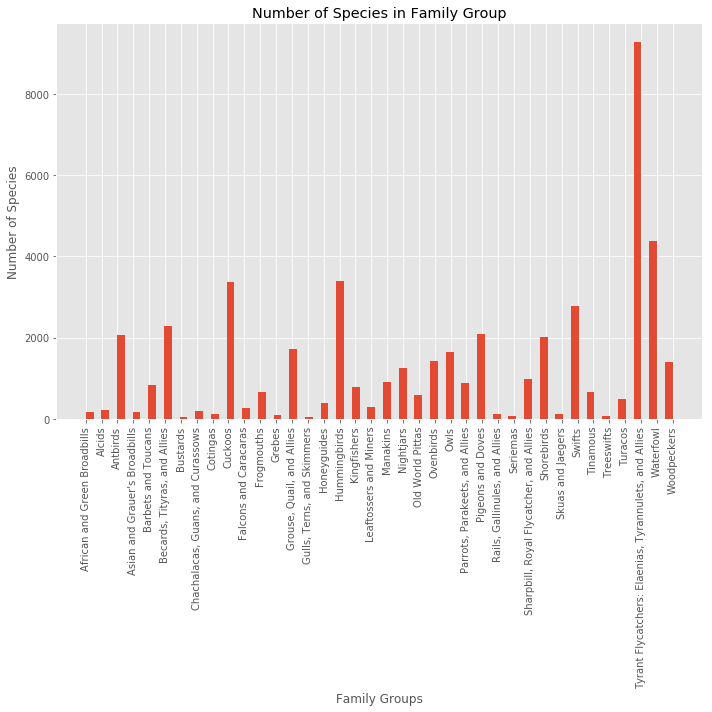

In [169]:
fig, ax = plt.subplots(figsize=(10,10))

ax = orders_df['species_group'].hist(bins=75);
plt.xticks(rotation=90);
ax.set_title('Number of Species in Family Group')
ax.set_xlabel('Family Groups')
ax.set_ylabel('Number of Species')

plt.tight_layout()

In [203]:
img_dir = 'images' # folder containing all other folders of images
paths = orders_df['file_path']
bucket = 'cwbirdsimages'

def resize_images_array(img_dir, file_paths):
    # arrays of image pixels
    img_arrays = []
    
    paths = []
    
    # loop through the dataframe that is linked to its label so that all images are in the same order
    for path in tqdm(file_paths):
        s3 = boto3.client('s3')
        try:
            obj = s3.get_object(Bucket=bucket, Key=f'{img_dir}/{path}')
            img_bytes = BytesIO(obj['Body'].read())
            open_img = Image.open(img_bytes)
            arr = np.array(open_img.resize((299,299))) # resize to 200,200. possible to play around with better or worse resolution
            img_arrays.append(arr)
            paths.append(path)
        except:
#             print(path) # get file_path of ones that fail to load
            continue
    return np.array(img_arrays)

In [ ]:
X = resize_images_array(img_dir, orders_df['file_path'][:47001])

 19%|█▉        | 9015/47001 [17:52<1:20:07,  7.90it/s] 

In [ ]:
print('length of sample: ', len(X))
X.shape

In [ ]:
# normalize the RBG values
X = X/255.0

In [ ]:
# grab numeric label
# VALUES MUST BE NP.ARRAYS

label = np.array(orders_df['order'][:47001].values)

In [ ]:
y = (label.reshape(-1,1) == orders_df['order'][:47001].unique()).astype(float)

In [ ]:
y[0]

In [ ]:
print('label shape: ', y.shape)
print('features shape: ', X.shape)

In [ ]:
n_categories = y.shape[1]

In [ ]:
n_categories

## Transfer Learning

In [201]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization # CNN
from tensorflow.keras.models import Model

from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop

from tensorflow.keras.callbacks import TensorBoard # graphical visual of loss and accuracy over the epochs of train and test set
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import datetime

tf.__version__

'2.2.0'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

In [ ]:
log_xcept = os.path.join("logs/orders_xception", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_xcept, histogram_freq=1)

In [ ]:
input_size = (299,299,3)

In [ ]:
def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

In [ ]:
transfer_model = create_transfer_model((299,299,3),n_categories)

In [ ]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [ ]:
_ = change_trainable_layers(transfer_model, 132)

In [ ]:
print_model_properties(transfer_model, 130)

In [ ]:
transfer_model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'], callbacks=[tensorboard_callback])

In [ ]:
xception_final = transfer_model.fit(X, y, batch_size=1000, epochs=5, validation_split=0.1)

In [ ]:
transfer_model.save('saved_models/orders_xception.h5')
# load_L_xception = tf.keras.models.load_model('saved_models/large_xception.h5')